In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor


In [2]:
# Load Data
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor()
)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

print(train_data)
print(test_data)

#Load data using DataLoaders
loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader (test_data, batch_size=100, shuffle=True, num_workers=1),
}

from torch.utils.data import DataLoader

# Create data loaders
loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}


cpu
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Training data: 60000 samples
Image shape: torch.Size([1, 28, 28])
Label: 5


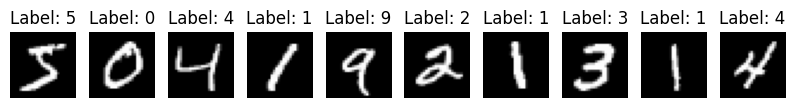

In [3]:
# Print dataset information
print(f'Training data: {len(train_data)} samples')

# Access and print the first sample
image, label = train_data[0]
print(f'Image shape: {image.shape}')
print(f'Label: {label}')

# Visualize the first 5 images
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    image, label = train_data[i]
    image = image.squeeze()  # Remove the channel dimension
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

## The Convolutional Neural Network

I will make has 2 Convolutional Layers, consisting of a 2D Convolution, ReLU Activation, and Max Pooling for Subsampling. The model then runs through a Feed Forward Network. 

### Steps of 2D Convolution

1. Filter: a small matrix of weights that slides over image,
2. Stride: number of pixels the filter moves at each step.
3. Padding: Extra pixels added at border of image to ensure filter can slide along edges of images.
4. Operation: For each position of the filter in the image:
       Multiply corresponding elements of filter, take a sum, and place into feature map

## Max Pooling

Max Pooling is a down-sampling operation to reduce spatial dimensions of feature map while retaining information. It takes a maximum from a small window (such as 2x2), and discards the rest. 

### Steps of Max Pooling 

1. Pooling Window: A small matrix that slides over input feature map
2. Stride: Number of pixels the window moves each step
3. Operation: Take the maximum value within the window, place this maximum value in the output pooled feature map

In [12]:
#Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, #number of channels in input image
                out_channels=16, #number of filters, 16 filters means 16 output channels
                kernel_size=5, #size of convolving kernel, in this case 5x5
                stride=1, #number of pixels to move kernel at each iteration
                padding=2, #padding with zero so output same as input
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  #2x2 kernel
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, #number of channels from first conv
                out_channels=32, #more filters to catch more detailed information
                kernel_size=5, #size of convolving kernel, in this case 5x5
                stride=1, #number of pixels to move kernel at each iteration
                padding=2, #padding with zero so output same as input
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  #2x2 kernel
        )
        self.out = nn.Linear(32*7*7,10) #By the end of pooling, 28x28 image reduced to 7x7 with 32 channels, 10 output classes (digits 0-9)

    def forward(self,x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(x.size(0), -1) #Flatten output, this converts to shape (batch, 32*7*7
        #after flattened, pass in to FFN
        output = self.out(x)
        return output

cnn = CNN().to(device)
print(cnn)

CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [13]:
#Cross Entropy Loss for Image Tasks
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.01)

In [20]:
num_epochs = 10

def train_model(num_epochs, cnn, loaders):
    cnn.train() # put model in training mode
    total_batches = len(loaders['train'])

    for epoch in range(num_epochs):
        for j, (images, labels) in enumerate(loaders['train']):
            images, labels = images.to(device), labels.to(device) # customize for device config

            # Forward
            predictions = cnn(images)
            loss = loss_function(predictions, labels) # use Cross Entropy Loss Function

            # Backward
            optimizer.zero_grad() # reset gradients
            loss.backward() # backprop
            optimizer.step() # update params

            # print for info
            if (j+1) % 100 == 0: # added condition to print every 100 steps
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{j+1}/{total_batches}], Loss: {loss.item():.4f}')

train_model(num_epochs, cnn, loaders)


Epoch [1/10], Step [100/600], Loss: 0.0426
Epoch [1/10], Step [200/600], Loss: 0.0319
Epoch [1/10], Step [300/600], Loss: 0.0361
Epoch [1/10], Step [400/600], Loss: 0.1681
Epoch [1/10], Step [500/600], Loss: 0.3253
Epoch [1/10], Step [600/600], Loss: 0.0313
Epoch [2/10], Step [100/600], Loss: 0.1068
Epoch [2/10], Step [200/600], Loss: 0.0514
Epoch [2/10], Step [300/600], Loss: 0.0947
Epoch [2/10], Step [400/600], Loss: 0.0335
Epoch [2/10], Step [500/600], Loss: 0.0114
Epoch [2/10], Step [600/600], Loss: 0.0077
Epoch [3/10], Step [100/600], Loss: 0.0104
Epoch [3/10], Step [200/600], Loss: 0.0149
Epoch [3/10], Step [300/600], Loss: 0.0162
Epoch [3/10], Step [400/600], Loss: 0.0024
Epoch [3/10], Step [500/600], Loss: 0.0302
Epoch [3/10], Step [600/600], Loss: 0.0192
Epoch [4/10], Step [100/600], Loss: 0.0102
Epoch [4/10], Step [200/600], Loss: 0.0190
Epoch [4/10], Step [300/600], Loss: 0.0006
Epoch [4/10], Step [400/600], Loss: 0.0474
Epoch [4/10], Step [500/600], Loss: 0.0333
Epoch [4/10

In [21]:
def test_model():
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total_labels = 0
        for images, labels in loaders['test']:
            # iterate through image, correct label in test data
            images, labels = images.to(device), labels.to(device) # use device config
            outputs = cnn(images) # call the model on these inputs
            _, predicted = torch.max(outputs.data, 1) # get the predicted letter from distributions
            total_labels += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Model Accuracy for Test Data {100 * correct / total_labels:.2f}%')

test_model()


Model Accuracy for Test Data 98.23%


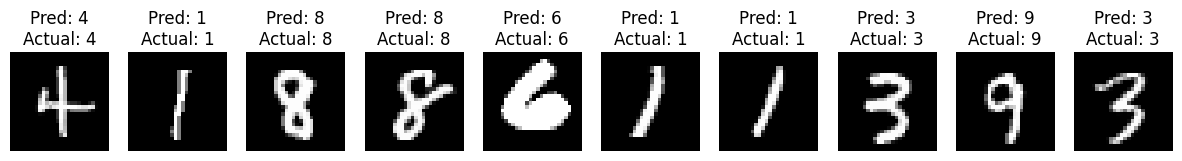

In [22]:
# Visualize the Inference
sample = next(iter(loaders['test']))  # load sample data from test
images, labels = sample
images, labels = images.to(device), labels.to(device)

# Get the model's predictions
cnn.eval()  # set the model to evaluation mode
with torch.no_grad():
    test_output = cnn(images[:10])  # get the outputs for the first 10 images
    predictions = torch.max(test_output, 1)[1].cpu().numpy().squeeze()
    expected_labels = labels[:10].cpu().numpy()

# Plot the images with their predicted and actual labels
fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[i].set_title(f'Predicted: {predictions[i]}')
    axes[i].axis('off')
plt.show()
